In [1]:
'''
Loads in IR Spectral data as numpy arrays
Anticipates row 1 to be frequencies
Uses Gaussian Kernel Density Estimation to find standard deviation
within absorption rates at various light frequencies
Possible issues later: Array sizing, standard deviation array is 1-D
Uploaded July 3, 2024
Ask Bishop for any clarifications
'''
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

In [2]:
#METHODS USED FOR DATA ANALYSIS AND VISUALIZATION


#Pass IRSpectra_File into this method in order to
#restructure the data into a two-dimensional array
#In the resulting array, column one stores
def restructureIRData(file):
    frequencyRow = file[0]
    #frequencyRow will contain one collection of the frequency range for each molecule
    for i in range(2, len(file)): #Start the range at 2 because we have already loaded in one set of frequencies
        frequencyRow = np.concatenate((frequencyRow, file[0]))
    absorptionRows = file[1]
    for i in range(2, len(file)):
        absorptionRows = np.concatenate((absorptionRows, file[i]))
    restructuredData = np.column_stack((frequencyRow, absorptionRows))
    print('After restructuring, your data has shape:', restructuredData.shape)
    return restructuredData

def createKernelDensityEstimator(data):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.25).fit(data)
    print('The KDE expects', kde.n_features_in_, 'features in an input')
    return kde

'''
#This plotting method is built to work on general data sizes, but it's horrible
#So, do not actually use this unless it becomes necessary
def plotKernelDensity(data, kde):
    x_domain = np.linspace(data[0][0], len(data)/3, 100)
    y_domain = np.linspace(-0.5, 1.5, 100)
    x, y = np.meshgrid(x_domain, y_domain)
    xy = np.vstack([x.ravel(), y.ravel()]).T
    z = np.exp(kde.score_samples(xy))
    z = z.reshape(x.shape)
    fig = plt.figure()
    cp = fig.add_subplot(111, projection='3d')
    cp.plot_surface(X=x, Y=y, Z=z, cmap='viridis')
    plt.title('Kernel Density Estimation (Seems wrong)')
    cp.set_xlabel('Frequency')
    cp.set_ylabel('Absorption')
    cp.set_zlabel('Density')
    plt.show()
'''

#This plotting method assumes your frequencies fall within 0 and 4000
def plotKernelDensityV1(data, kde):
    x_domain = np.linspace(0, 4000, 100)
    y_domain = np.linspace(-0.5, 1.5, 100)
    x, y = np.meshgrid(x_domain, y_domain)
    xy = np.vstack([x.ravel(), y.ravel()]).T
    z = np.exp(kde.score_samples(xy))
    z = z.reshape(x.shape)
    fig = plt.figure()
    cp = fig.add_subplot(111, projection='3d')
    cp.plot_surface(X=x, Y=y, Z=z, cmap='viridis')
    plt.title('KDE plot')
    cp.set_xlabel('Frequency')
    cp.set_ylabel('Absorption')
    cp.set_zlabel('Density')
    plt.show()

#Creates an array of standard deviations of level curves of
#absorption vs. density for fixed frequencies. Indices correspond
#to frequencies
def findStandardDeviations(data, kde):
    # Create frequency, std. deviation array
    # Define the frequency range and absorption range
    frequency_range = np.arange(data[0][0], len(data)/3)
    absorption_range = np.linspace(-0.5, 1.5,100)  # You can adjust the number
    #of points in the absorption range with the third parameter
    # Prepare a 2D grid of points
    std_devs = np.zeros(len(frequency_range))
    variance = np.zeros(len(frequency_range))
    epsilon = 1e-10  # Prevent divide by zero error
    for i, freq in enumerate(frequency_range):
        # Create an array of points with the current frequency and varying absorption values
        points = np.vstack([np.full(absorption_range.shape, freq), absorption_range]).T
        # Evaluate the KDE at these points
        log_densities = kde.score_samples(points)
        densities = np.exp(log_densities)
        # Ensure densities are not all zeros
        sum_densities = np.sum(densities) + epsilon
        # Calculate the weighted mean and variance
        weighted_mean = np.sum(
            absorption_range * densities) / sum_densities  # We use a weighted mean because each absorption
        # value should only contribute to the average according to its density
        weighted_var = np.sum(densities * (absorption_range - weighted_mean) ** 2) / (sum_densities)
        std_devs[i] = np.sqrt(weighted_var)
    # The result is stored in std_devs, indices correspond to frequencies
    return std_devs

def plotFrequencyVsStandardDeviation(data, std_devs_array):
    frequency_range = np.arange(data[0][0], len(data)/3)
    fig = plt.figure()
    sdPlot = fig.add_subplot(111)
    sdPlot.plot(frequency_range, std_devs_array)
    sdPlot.set_xlabel('Frequency')
    sdPlot.set_ylabel('Standard Deviation')
    plt.show()

In [3]:
IRSpectra_File = np.load('<LOAD IR SPECTRA DATA HERE>')
print('The file you have loaded in has shape:', IRSpectra_File.shape)
workingData = restructureIRData(IRSpectra_File)
workingKDE = createKernelDensityEstimator(workingData)

The file you have loaded in has shape: (4, 3550)
After restructuring, your data has shape: (10650, 2)
The KDE expects 2 features in an input


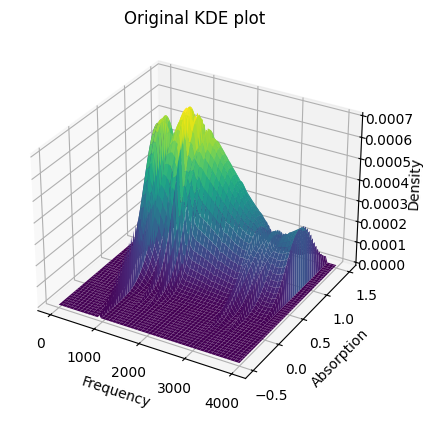

In [4]:
#plotKernelDensity(workingData, workingKDE)
plotKernelDensityV1(workingData, workingKDE)

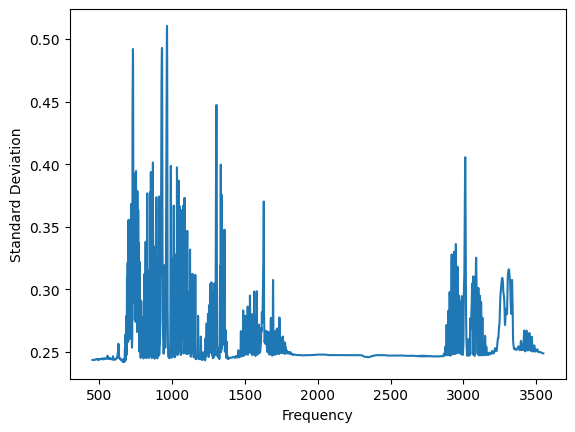

In [5]:
plotFrequencyVsStandardDeviation(workingData, findStandardDeviations(workingData, workingKDE))